In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

pip install statsmodels==0.10.0rc2 --pre

In [3]:
from pmdarima.arima.utils import ndiffs

In [4]:
import matplotlib.dates as mdates

In [5]:
sns.set_style('darkgrid')

In [6]:
plt.rcParams['figure.figsize'] = (13,7)

In [7]:
shampoo = pd.read_csv(r'C:\Users\ssiva\OneDrive\Documents\Machine Learning_\Machine Learning\Shampoo Timeseries\shampoo.csv')

In [8]:
shampoo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
Month    36 non-null object
Sales    36 non-null float64
dtypes: float64(1), object(1)
memory usage: 656.0+ bytes


In [9]:
shampoo.describe()

,Sales
count,36.000000
mean,312.600000
std,148.937164
min,119.300000
25%,192.450000
50%,280.150000
75%,411.100000
max,682.000000


In [10]:
shampoo.head()

,Month,Sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


In [11]:
shampoo['Datetime'] = shampoo['Month'].apply(lambda date: pd.datetime(month = int(date.split('-')[1]), day = 1,year = 2016 + int(date.split('-')[0])))

In [12]:
shampoo = shampoo[['Sales','Datetime']]

In [13]:
shampoo.head()

,Sales,Datetime
0,266.0,2017-01-01
1,145.9,2017-02-01
2,183.1,2017-03-01
3,119.3,2017-04-01
4,180.3,2017-05-01


In [14]:
shampoo['Sales'].values

array([266. , 145.9, 183.1, 119.3, 180.3, 168.5, 231.8, 224.5, 192.8,
       122.9, 336.5, 185.9, 194.3, 149.5, 210.1, 273.3, 191.4, 287. ,
       226. , 303.6, 289.9, 421.6, 264.5, 342.3, 339.7, 440.4, 315.9,
       439.3, 401.3, 437.4, 575.5, 407.6, 682. , 475.3, 581.3, 646.9])

In [15]:
result = adfuller(shampoo['Sales'].values)

In [16]:
result

(3.060142083641181,
 1.0,
 10,
 25,
 {'1%': -3.7238633119999998, '10%': -2.6328004, '5%': -2.98648896},
 278.9972644263031)

In [17]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 3.060142
p-value: 1.000000


In [18]:
sales = shampoo['Sales']

### Since p-value > 0.05, need to difference

In [19]:
sales.diff().values

array([   nan, -120.1,   37.2,  -63.8,   61. ,  -11.8,   63.3,   -7.3,
        -31.7,  -69.9,  213.6, -150.6,    8.4,  -44.8,   60.6,   63.2,
        -81.9,   95.6,  -61. ,   77.6,  -13.7,  131.7, -157.1,   77.8,
         -2.6,  100.7, -124.5,  123.4,  -38. ,   36.1,  138.1, -167.9,
        274.4, -206.7,  106. ,   65.6])

In [20]:
type(shampoo.loc[0,'Datetime'])

pandas._libs.tslibs.timestamps.Timestamp

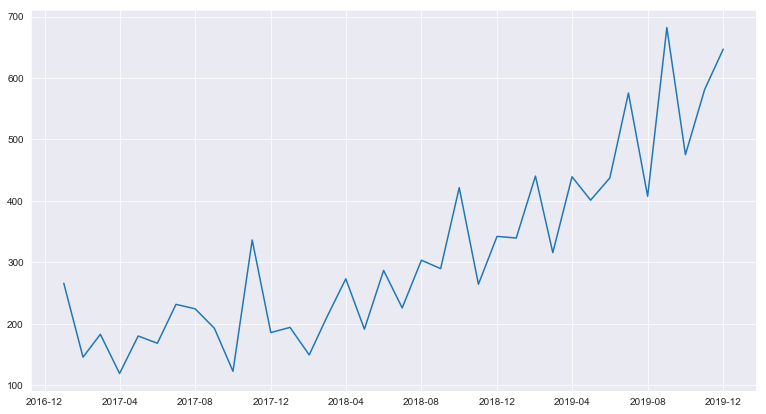

In [21]:
plt.plot(shampoo['Datetime'],shampoo['Sales'])

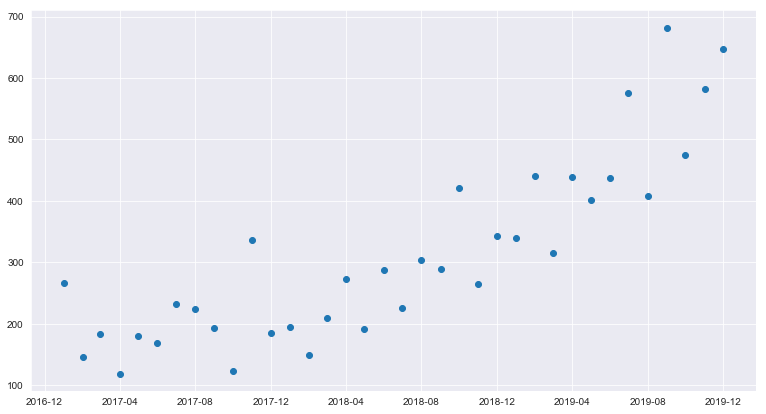

In [22]:
plt.plot_date(shampoo['Datetime'],shampoo['Sales'])

In [23]:
shampoo['Datetime'] = pd.to_datetime(shampoo['Datetime'])

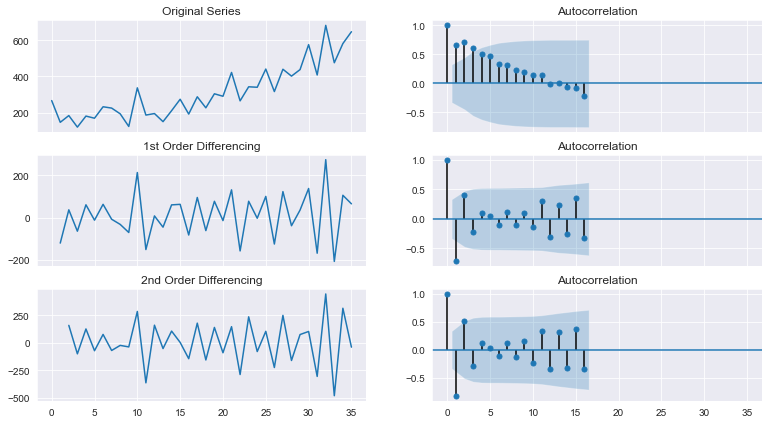

In [24]:
fig, axes = plt.subplots(3, 2, sharex=True)
#Original Series
axes[0,0].plot(shampoo['Sales'].values)
axes[0, 0].set_title('Original Series')
plot_acf(sales.values, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(sales.diff().values) 
axes[1, 0].set_title('1st Order Differencing')
plot_acf(sales.diff().dropna().values, ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(sales.diff().diff().values)
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(sales.diff().diff().dropna().values, ax=axes[2, 1])
plt.show()

In [25]:
sales.std()

148.93716412347473

In [26]:
sales.diff().dropna().std()

109.26133131629142

In [27]:
sales.diff().diff().dropna().std()

204.15860147044307

### Stationarity is reached after 1 differencing but goes to negative in acf plot really quickly so might not need differencing (d = 0) 
### The acf plot of Original Series suggests that q should equal 3 but I will go with the simpler q = 2 for now.
### Of the three, 1st order differencing has the lowerst standard deviation.  I might choose d = 1 later, but for now will choose d = 0.

In [31]:
y = sales.values

## Adf Test
ndiffs(y, test='adf')  # 1


1

In [29]:
# KPSS test
ndiffs(y, test='kpss')  # 1

1

In [32]:
# PP test:
ndiffs(y, test='pp')  # 0

0

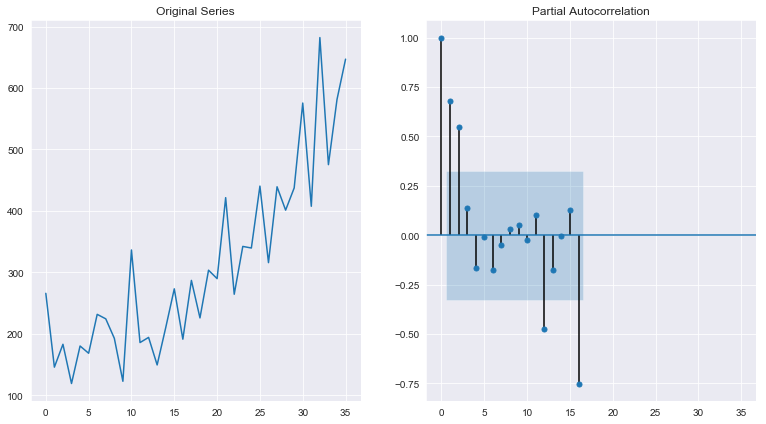

In [33]:
# Plotting pacf to determine which p to use for lags
fig,ax = plt.subplots(1,2,sharex = True)
ax[0].plot(sales.values)
ax[0].set_title('Original Series')
plot_pacf(sales,ax = ax[1])
plt.show()

The acf plot suggests that p should equal 2

### If time series is under differenced (stationarity is there or number of lags before first negative value is reached is 10 or more in acf plot) add AR terms (increase p)
### If time series is over differenced (negative value is reached really quickly in acf plot), add MA terms (increase q)
### I am currently setting d = 0, p = 3 (since there are 11 lags indicating under differentiation), and q = 2

# Building the ARIMA model

In [34]:
model = ARIMA(sales,order=(3,0,2))

In [35]:
model.fit = model.fit(disp = 0)

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

### There is an error since Original series is not stationary.  I am using d = 1 and the corresponding p and q values needed

Text(0.5,1,'PACF')

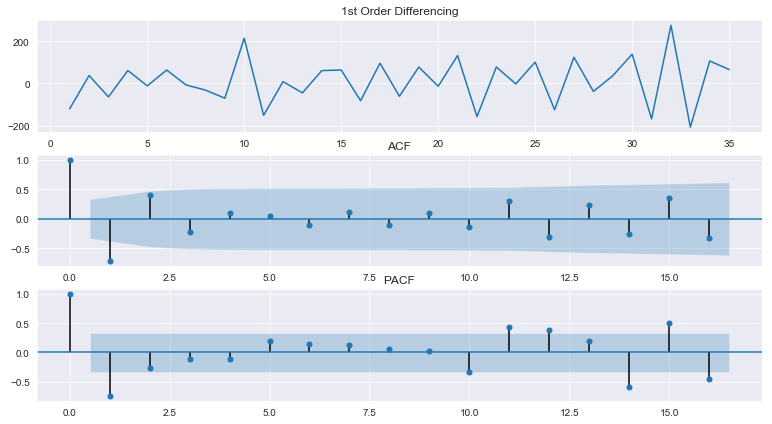

In [37]:
fig,ax = plt.subplots(nrows = 3,ncols=1)
ax[0].plot(sales.diff().dropna())
ax[0].set_title('1st Order Differencing')

plot_acf(sales.diff().dropna(),ax = ax[1])
ax[1].set_title('ACF')

plot_pacf(sales.diff().dropna(),ax = ax[2])
ax[2].set_title('PACF')


### Using d = 1, I am selecting p = 0 and q = 1 since negative value is reached quickly on the ACF plot

In [39]:
model = ARIMA(sales,order = (0,1,1))

In [40]:
model_fit = model.fit(disp = 0)

In [41]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   35
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -201.506
Method:                       css-mle   S.D. of innovations             75.686
Date:                Thu, 30 Apr 2020   AIC                            409.013
Time:                        11:21:42   BIC                            413.679
Sample:                             1   HQIC                           410.623
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.0649      3.520      3.428      0.002       5.166      18.964
ma.L1.D.Sales    -0.7495      0.098     -7.623      0.000      -0.942      -0.557
                                    Root

#### since P>|z| < 0.05, X (ma1 coefficient) is significant and therefore the model is good

### Checking Residuals

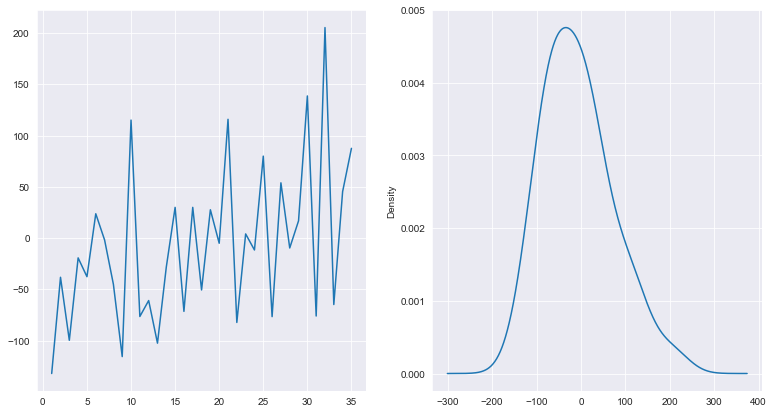

In [42]:
residuals = model_fit.resid
fig,ax = plt.subplots(1,2)
residuals.plot(ax = ax[0])
residuals.plot(kind = 'kde',ax = ax[1])

In [43]:
residuals.mean()

-6.680702594928689

since the mean of the errors is increasing over time, it suggests the model is not fully explaining relationship between MA terms and differenced y output 

# Plotting Predictions

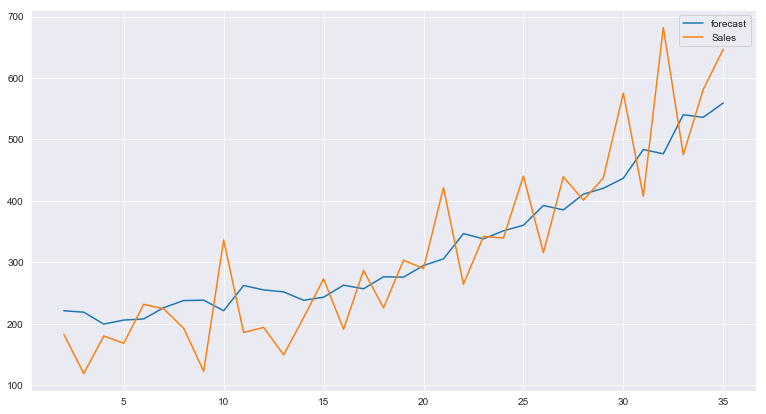

In [44]:
model_fit.plot_predict(dynamic=False) # Setting dynamic = to false means predictions are plotted for in-sample observations
plt.show()

In [ ]:
shampoo = shampoo.set_index('Datetime')
shampoo = shampoo.set_index(shampoo.index.to_pydatetime())

In [86]:
sales = shampoo['Sales']

In [87]:
train = sales[0:28]
test = sales[28:]

In [88]:
train_model = ARIMA(train,order = (0,1,1))
fitted = model.fit(disp = -1)

C:\Users\ssiva\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\ssiva\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [90]:
fc, se, conf = fitted.forecast(8, alpha=0.05)  # 95% conf

In [91]:
fc_series = pd.Series(fc,index = test.index)
lower_series = pd.Series(conf[:,0],index = test.index)
upper_series = pd.Series(conf[:,1],index = test.index)

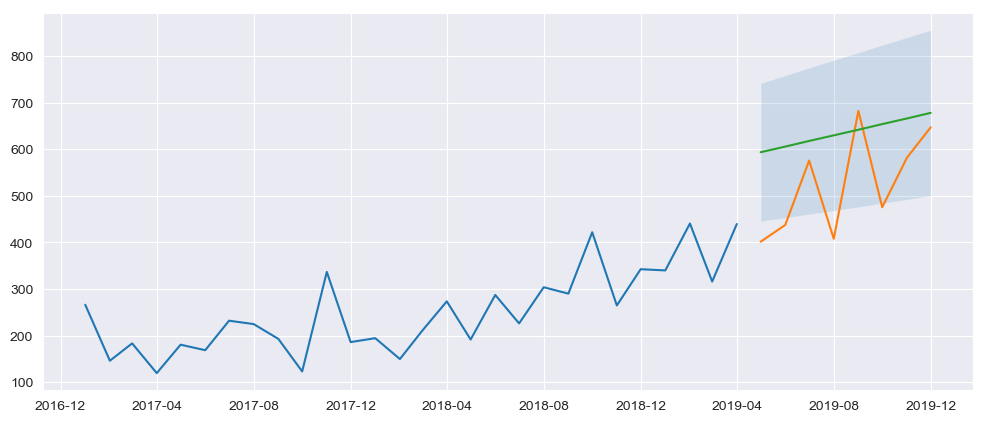

In [94]:
plt.figure(figsize = (12,5),dpi = 100)
plt.plot(train,label = 'Training')
plt.plot(test,label = 'Actual')
plt.plot(fc_series,label = 'Forecasted')
plt.fill_between(test.index,lower_series,upper_series,alpha = 0.15)
# plt.title('Forecast vs Actuals')
# plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
# The predictions had some values outside of the confidence interval and were consistently higher than the actuals